### Requirements

In [ ]:
!pip install torchvision -q

### Imports

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

from PIL import Image
from datasets import load_dataset

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys

# Path to achitecture .py file
project_path = '/content/drive/MyDrive/STAT 542 Project'


# Add the path to sys.path
if project_path not in sys.path:
    sys.path.append(project_path)

In [5]:
!ls "/content/drive/My Drive/STAT 542 Project"

 bird_classification.ipynb     ResNet_pytorch.py
 fashion_mnist_pytorch.ipynb  'STAT 542 Final Project .gdoc'
 __pycache__


### Import ResNet Functions

In [23]:
try:
    from ResNet_pytorch import resnet34
    print("Successfully imported ResNet_pytorch.py")
except ImportError:
    print("Error: Could not import ResNet_pytorch.py.")
    print("Please make sure 'ResNet_pytorch.py' is in the same directory.")
    exit()

Successfully imported ResNet_pytorch.py


### SetUp

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Hyperparameter

In [48]:
NUM_CLASSES = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 3

### Load Dataset

In [10]:
df = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/296M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5794 [00:00<?, ? examples/s]

In [12]:
def preprocess(dict_object):
    '''
    Function to apply the image_transforms
    Agg:
      dict_object - single object from dictionary input dataset
    '''
    dict_object['pixel_values'] = image_transforms(dict_object['image'].convert("RGB"))
    return dict_object

In [13]:
train_dataset = df['train'].map(
    preprocess,
    remove_columns=['image'],
    batched=False
)
test_dataset = df['test'].map(
    preprocess,
    remove_columns=['image'],
    batched=False
)

train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Map:   0%|          | 0/5994 [00:00<?, ? examples/s]

Map:   0%|          | 0/5794 [00:00<?, ? examples/s]

Train samples: 5994, Test samples: 5794


### Normalization

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize(256),                 # Resize shorter side to 256
    transforms.CenterCrop(224),             # Crop to 224x224
    transforms.ToTensor(),                  # Convert PIL image to Tensor
    transforms.Normalize(                   # ImageNet normalization
        mean=[0.485, 0.456, 0.406],         # Average value of RGB pixel
        std=[0.229, 0.224, 0.225]
    ),
])

### Data Loader

In [21]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

### Model Initialization

In [32]:
model = resnet34(num_classes=200)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
test_accuracies = []
test_losses = []

### Model Setup

In [37]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """Handles the training process and evaluates after each epoch."""
    model.train()
    print("\nStarting Training...")

    train_losses.clear()
    test_accuracies.clear()
    test_losses.clear()

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        end_time = time.time()

        # Evaluation Step
        acc, test_loss = evaluate_model(model, test_loader, criterion, device)
        test_accuracies.append(acc)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1} finished. Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.2f}% | Time: {end_time - start_time:.2f}s")

    print("\nTraining complete.")

In [35]:
def evaluate_model(model, test_loader, criterion, device):
    """Calculates the Top-1 accuracy AND the average test loss."""
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    total_loss = 0.0 # To accumulate the total loss

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss

            # Accumulate loss weighted by batch size
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_samples
    avg_loss = total_loss / total_samples # Calculate average loss

    return accuracy, avg_loss

### Model Training

In [41]:
train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)


Starting Training...


Evaluating: 100%|██████████| 182/182 [01:12<00:00,  2.53it/s]


Epoch 1 finished. Train Loss: 3.8537 | Test Loss: 3.9211 | Test Acc: 11.70% | Time: 81.32s


Evaluating: 100%|██████████| 182/182 [01:09<00:00,  2.62it/s]


Epoch 2 finished. Train Loss: 3.8878 | Test Loss: 3.9772 | Test Acc: 10.60% | Time: 78.13s


Evaluating: 100%|██████████| 182/182 [01:08<00:00,  2.64it/s]

Epoch 3 finished. Train Loss: 3.5429 | Test Loss: 3.9089 | Test Acc: 12.53% | Time: 76.65s

Training complete.


### Model Evaluation

In [ ]:
acc, avg_loss = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"Final ResNet-152 Top-1 Accuracy: {acc:.2f}%")

### Transfer Learning with Pretrained ResNet-152

In [50]:
# Load the official PyTorch ResNet-152 with weights pre-trained on ImageNet
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# Freeze all pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move model to device and set up optimizer
model = model.to(DEVICE)

# 5Optimize ONLY the parameters of the new final layer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 181MB/s]


In [53]:
train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)


Starting Training...


Evaluating: 100%|██████████| 182/182 [01:16<00:00,  2.38it/s]


Epoch 1 finished. Train Loss: 5.0341 | Test Loss: 4.6017 | Test Acc: 19.99% | Time: 85.77s


Evaluating: 100%|██████████| 182/182 [01:16<00:00,  2.38it/s]


Epoch 2 finished. Train Loss: 4.2462 | Test Loss: 3.9904 | Test Acc: 37.90% | Time: 84.62s


Evaluating: 100%|██████████| 182/182 [01:19<00:00,  2.30it/s]

Epoch 3 finished. Train Loss: 3.6251 | Test Loss: 3.5046 | Test Acc: 47.62% | Time: 82.49s

Training complete.


In [54]:
acc, avg_loss = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"\nFinal ResNet-152 Top-1 Accuracy: {acc:.2f}%")

Evaluating: 100%|██████████| 182/182 [01:16<00:00,  2.38it/s]

Final ResNet-152 Top-1 Accuracy: 47.62%


### Learning Rate Schedule and Weight Decay

In [56]:
WEIGHT_DECAY = 1e-4

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY # Applies L2 regularization
)

In [57]:
STEP_SIZE = 7  # Reduce LR every 7 epochs
GAMMA = 0.1    # Reduce LR by a factor of 10 (new_lr = current_lr * 0.1)

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA
)

In [58]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Handles the training process and evaluates after each epoch."""
    model.train()
    print("\nStarting Training...")

    train_losses.clear()
    test_accuracies.clear()
    test_losses.clear()

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"LR updated. New LR: {optimizer.param_groups[0]['lr']:.8f}")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        end_time = time.time()

        # Evaluation Step
        acc, test_loss = evaluate_model(model, test_loader, criterion, device)
        test_accuracies.append(acc)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1} finished. Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.2f}% | Time: {end_time - start_time:.2f}s")

    print("\nTraining complete.")

In [60]:
train_model(model, train_loader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)


Starting Training...


Epoch 1/3: 100%|██████████| 188/188 [01:30<00:00,  2.08it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:19<00:00,  2.30it/s]


Epoch 1 finished. Train Loss: 3.2488 | Test Loss: 3.1049 | Test Acc: 52.78% | Time: 90.19s


Epoch 2/3: 100%|██████████| 188/188 [01:27<00:00,  2.16it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:18<00:00,  2.31it/s]


Epoch 2 finished. Train Loss: 2.7097 | Test Loss: 2.8063 | Test Acc: 54.42% | Time: 87.17s


Epoch 3/3: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:19<00:00,  2.29it/s]

Epoch 3 finished. Train Loss: 2.3827 | Test Loss: 2.5565 | Test Acc: 57.97% | Time: 84.75s

Training complete.


In [61]:
acc, avg_loss = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"\nFinal ResNet-152 Top-1 Accuracy: {acc:.2f}%")

Evaluating: 100%|██████████| 182/182 [01:17<00:00,  2.35it/s]


Final ResNet-152 Top-1 Accuracy: 57.97%


### Advanced Data Augmentation

In [62]:
train_transforms = transforms.Compose([
    # Standard ResNet augmentations
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), # scale change to 1.0 instead of 0.5
    transforms.RandomHorizontalFlip(),

    # Advanced Color and Spatial Augmentation
    transforms.ColorJitter(
        brightness=0.3, # Adjust brightness up to 30%
        contrast=0.3,   # Adjust contrast up to 30%
        saturation=0.3, # Adjust saturation up to 30%
        hue=0.1         # Adjust hue up to 10%
    ),
    transforms.RandomRotation(degrees=15), # Rotate up to 15 degrees

    # Final steps
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [64]:
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        # Generate a random lambda value from a Beta distribution
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    # Get a random permutation of indices
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Mix the data and labels
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Loss function for MixUp'''
    # Loss is calculated as a linear combination of the losses for both targets
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [65]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Handles the training process and evaluates after each epoch."""
    model.train()
    print("\nStarting Training...")

    train_losses.clear()
    test_accuracies.clear()
    test_losses.clear()

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):

            # Unpack and prepare data
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            # Apply MixUp
            mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.2, device=device)

            optimizer.zero_grad()

            # Forward pass with mixed images
            outputs = model(mixed_images)

            # Calculate MixUp loss
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)

            loss.backward()
            optimizer.step()

            # The running_loss calculation remains the same, but loss is now the MixUp loss
            running_loss += loss.item()

        scheduler.step()
        print(f"LR updated. New LR: {optimizer.param_groups[0]['lr']:.8f}")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        end_time = time.time()

        # Evaluation Step
        acc, test_loss = evaluate_model(model, test_loader, criterion, device)
        test_accuracies.append(acc)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1} finished. Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.2f}% | Time: {end_time - start_time:.2f}s")

    print("\nTraining complete.")

In [66]:
train_model(model, train_loader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)


Starting Training...


Epoch 1/3: 100%|██████████| 188/188 [01:29<00:00,  2.10it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:17<00:00,  2.36it/s]


Epoch 1 finished. Train Loss: 2.6608 | Test Loss: 2.4103 | Test Acc: 59.77% | Time: 89.57s


Epoch 2/3: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:18<00:00,  2.33it/s]


Epoch 2 finished. Train Loss: 2.4972 | Test Loss: 2.2856 | Test Acc: 60.27% | Time: 86.07s


Epoch 3/3: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]


LR updated. New LR: 0.00010000


Evaluating: 100%|██████████| 182/182 [01:19<00:00,  2.29it/s]

Epoch 3 finished. Train Loss: 2.3131 | Test Loss: 2.1734 | Test Acc: 61.86% | Time: 85.47s

Training complete.


In [67]:
acc, avg_loss = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"\nFinal ResNet-152 Top-1 Accuracy: {acc:.2f}%")

Evaluating: 100%|██████████| 182/182 [01:16<00:00,  2.38it/s]


Final ResNet-152 Top-1 Accuracy: 61.86%


### Unfreeze the Model and Lower the LR

In [72]:
NEW_LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
STEP_SIZE = 3
GAMMA = 0.1
NUM_EPOCHS = 6

In [69]:
# Unfreeze All Layers
for param in model.parameters():
    param.requires_grad = True

# Reinitialize
optimizer = optim.Adam(
    model.parameters(),
    lr=NEW_LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA
)

In [73]:
train_model(model, train_loader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)


Starting Training...


Epoch 1/6: 100%|██████████| 188/188 [02:17<00:00,  1.37it/s]


LR updated. New LR: 0.00000100


Evaluating: 100%|██████████| 182/182 [01:19<00:00,  2.28it/s]


Epoch 1 finished. Train Loss: 2.1802 | Test Loss: 1.8378 | Test Acc: 66.17% | Time: 137.21s


Epoch 2/6: 100%|██████████| 188/188 [02:11<00:00,  1.43it/s]


LR updated. New LR: 0.00000100


Evaluating: 100%|██████████| 182/182 [01:20<00:00,  2.26it/s]


Epoch 2 finished. Train Loss: 1.6779 | Test Loss: 1.1570 | Test Acc: 70.00% | Time: 131.82s


Epoch 3/6: 100%|██████████| 188/188 [02:11<00:00,  1.43it/s]


LR updated. New LR: 0.00000010


Evaluating: 100%|██████████| 182/182 [01:20<00:00,  2.27it/s]


Epoch 3 finished. Train Loss: 1.4457 | Test Loss: 1.1151 | Test Acc: 70.62% | Time: 131.77s


Epoch 4/6: 100%|██████████| 188/188 [02:11<00:00,  1.43it/s]


LR updated. New LR: 0.00000010


Evaluating: 100%|██████████| 182/182 [01:20<00:00,  2.27it/s]


Epoch 4 finished. Train Loss: 1.3589 | Test Loss: 1.0975 | Test Acc: 70.78% | Time: 131.78s


Epoch 5/6: 100%|██████████| 188/188 [02:11<00:00,  1.43it/s]


LR updated. New LR: 0.00000010


Evaluating: 100%|██████████| 182/182 [01:20<00:00,  2.27it/s]


Epoch 5 finished. Train Loss: 1.3337 | Test Loss: 1.0892 | Test Acc: 71.00% | Time: 131.40s


Epoch 6/6: 100%|██████████| 188/188 [02:11<00:00,  1.42it/s]


LR updated. New LR: 0.00000010


Evaluating: 100%|██████████| 182/182 [01:20<00:00,  2.27it/s]

Epoch 6 finished. Train Loss: 1.5910 | Test Loss: 1.0969 | Test Acc: 70.97% | Time: 131.95s

Training complete.


In [74]:
acc, avg_loss = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"\nFinal ResNet-152 Top-1 Accuracy: {acc:.2f}%")

Evaluating: 100%|██████████| 182/182 [01:16<00:00,  2.37it/s]


Final ResNet-152 Top-1 Accuracy: 70.97%


### Loss Comparison

In [77]:
def plot_training_results(train_losses, test_losses, accuracies, num_epochs):
    """Plots the training/test losses on one figure and test accuracy on another."""
    epochs = np.arange(1, num_epochs + 1)

    # --- Plot Loss Comparison (Training vs. Test) ---
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker='x', color='red', linestyle='--')

    plt.title('Loss Comparison Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (CrossEntropy)')
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.savefig('loss_comparison.png')
    plt.show()
    plt.close()

    # --- Plot Accuracy --- (Unchanged)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, accuracies, label='Test Accuracy', marker='o', color='green')
    plt.title('Test Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.savefig('loss_comparison.png')
    plt.show()
    plt.close()

    print("Loss comparison saved to loss_comparison.png")
    print("Test accuracy saved to test_accuracy.png")

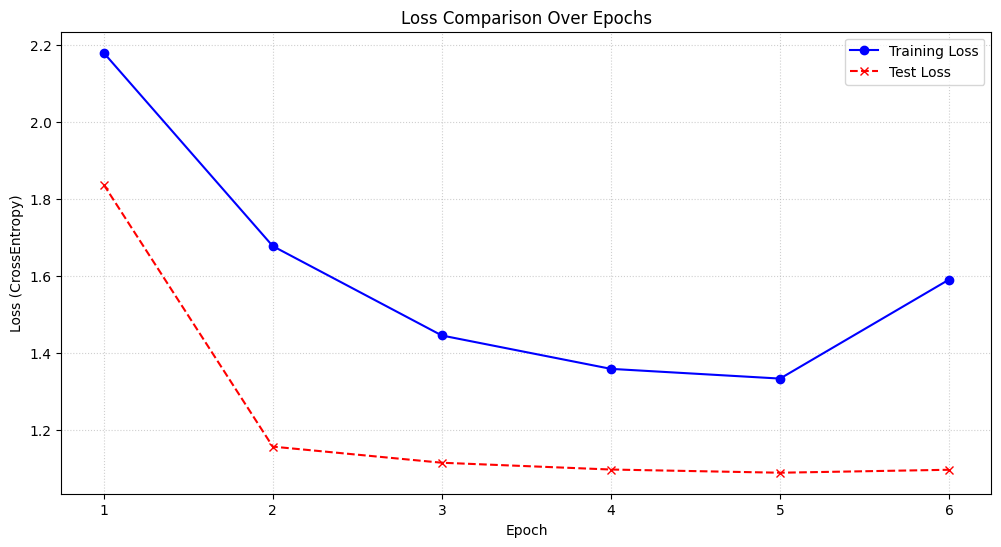

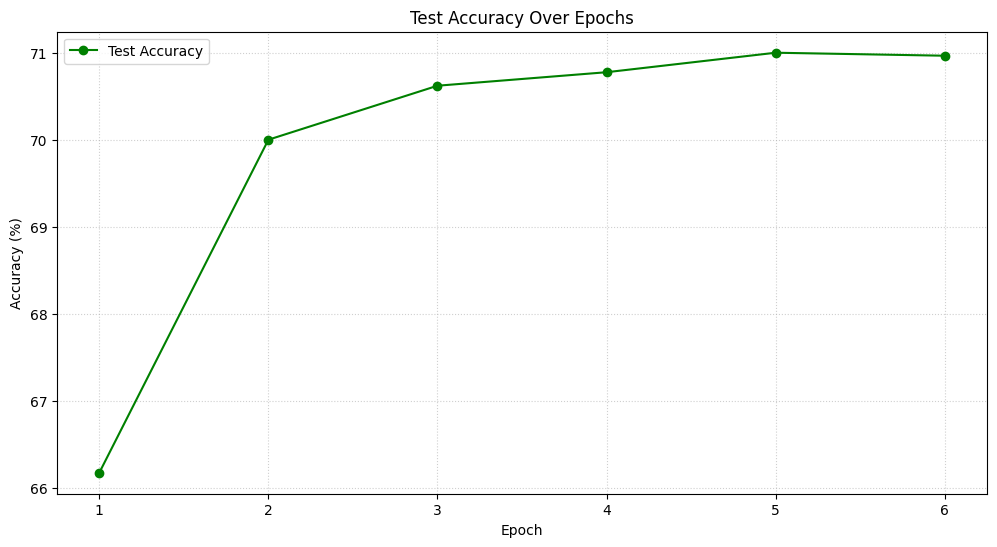

Loss comparison saved to loss_comparison.png
Test accuracy saved to test_accuracy.png


In [78]:
plot_training_results(train_losses, test_losses, test_accuracies, NUM_EPOCHS)

### Cuda

In [28]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 304595 KiB |  14830 MiB |  20403 MiB |  20106 MiB |
|       from large pool | 214784 KiB |  14741 MiB |  20315 MiB |  20105 MiB |
|       from small pool |  89811 KiB |     88 MiB |     88 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 304595 KiB |  14830 MiB |  20403 MiB |  20106 MiB |
|       from large pool | 214784 KiB |  14741 MiB |  20315 MiB |

In [51]:
torch.cuda.empty_cache()